In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
FILE1 = "Arrest_Data_from_2010_to_Present.csv"

df_la = pd.read_csv(FILE1, header=0, infer_datetime_format=True, parse_dates=['Arrest Date'])
df_la['Year'] = df_la['Arrest Date'].apply(lambda t:t.year)

In [3]:
(df_la[df_la['Year'] == 2018]).count()['Report ID']

104277

In [13]:
area_counts = df_la[df_la['Year'] == 2018][['Area ID','Report ID']].groupby('Area ID').count()
area_counts.max()

Report ID    10951
dtype: int64

In [5]:
charge_groups = ('Vehicle Theft', 'Burglary', 'Receive Stolen Property', 'Robbery')
df_la[(df_la['Year']==2018) & (df_la['Charge Group Description'].isin(charge_groups))]['Age'].quantile(0.95)

52.0

In [6]:
drop_charge_groups = ('Pre-Delinquency', 'Non-Criminal Detention')
mask = (df_la['Year']==2018) & ~((df_la['Charge Group Description'].isnull()) | (df_la['Charge Group Description'].isin(drop_charge_groups)))
mean_ages = df_la[mask].groupby('Charge Group Description').mean()['Age']
zscore = (mean_ages - mean_ages.mean())/mean_ages.std()
zscore.abs().max()

2.1278699344353633

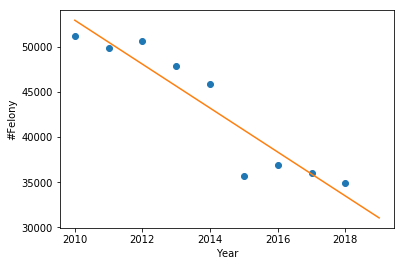

31037.805555555969

In [7]:
year_counts = df_la[(df_la['Arrest Type Code']=='F') & (df_la['Year']<=2018)][['Year', 'Report ID']].groupby('Year').count()

X = np.array(year_counts.index).reshape(-1, 1)
Y = year_counts['Report ID']

model = LinearRegression()
model.fit(X, Y)

Xnew = np.array([2010, 2019])
Ynew = model.predict(Xnew.reshape(-1, 1))
plt.plot(X, Y, 'o')
plt.plot(Xnew, Ynew)
plt.xlabel('Year')
plt.ylabel('#Felony')
plt.show()
Ynew[1]
#df_la.head()

In [8]:
def calc_dist(location, R0):
    R1 = location
    RADIAN = 180/np.pi
    RADIUS = 6371
    dP = (R1[0]-R0[0])/RADIAN
    dL = (R1[1]-R0[1])/RADIAN
    mP = (R1[0]+R0[0])/2/RADIAN
    #dist = RADIUS * np.sqrt(((R1[1]-R0[1])/RADIAN)**2.0 + (np.cos((R1[0]+R0[0])/2.0/RADIAN)*(R1[0]-R0[0])/RADIAN)**2.0)
    dist = RADIUS * np.sqrt(dP**2.0 + (np.cos(mP)*dL)**2.0)
    return dist

R_building = 34.050536, -118.247861
df_la['Lattitude'] = df_la['Location'].apply(lambda t:float(t[1:-1].split(',')[0]))
df_la['Longitude'] = df_la['Location'].apply(lambda t:float(t[1:-1].split(',')[1]))

ser_dist = calc_dist([df_la['Lattitude'], df_la['Longitude']], R_building)
    

In [9]:
df_la[(df_la['Year'] == 2018) & (ser_dist<=2) & (df_la['Location'] != '(0, 0)')]['Report ID'].count()

11461

In [10]:
mask = (df_la['Year']==2018)&(df_la['Address'].str.contains('PICO'))
loc_mean = df_la[mask][['Lattitude', 'Longitude']].mean()
loc_std = df_la[mask][['Lattitude', 'Longitude']].std()
mask_outlier = ((df_la[mask][['Lattitude', 'Longitude']] - loc_mean).abs() > loc_std*2).any(axis=1)
count = df_la[mask][~mask_outlier][['Longitude']].count()[0]
min_lg = df_la[mask][~mask_outlier][['Longitude']].min()[0]
max_lg = df_la[mask][~mask_outlier][['Longitude']].max()[0]
loc_min = df_la[mask & (df_la['Longitude'] == min_lg)][['Lattitude', 'Longitude']].iloc[0, :]
loc_max = df_la[mask & (df_la['Longitude'] == max_lg)][['Lattitude', 'Longitude']].iloc[0, :]
blvd_len = calc_dist(loc_min, loc_max)
count/blvd_len


27.656599084552607

In [11]:
mask = (df_la['Year']<=2018) & ~(df_la['Charge Group Code'].isnull()) & ~(df_la['Charge Group Code'] == 99)
area_counts = df_la[['Report ID', 'Charge Group Code', 'Area ID']][mask].groupby(['Charge Group Code', 'Area ID']).count().unstack(1)
total_freq = area_counts.sum(axis=1) / area_counts.sum().sum()
area_freq = area_counts / area_counts.sum()
con_freq = np.array(area_freq)/np.array(total_freq).reshape(-1, 1)
np.mean(sorted(con_freq.reshape(-1))[-5:])

3.515076379865202